# Multimodal AI Model for Stroke Identification: Integrating Voice Analysis and Facial Image Processing 

In [2]:
# ==============================
# 1. MOUNT + IMPORTS
# ==============================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import EfficientNet_B0_Weights
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import hashlib
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BATCH_SIZE = 45
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

Using device: cuda


In [3]:
import os

# New root path (local PC)
ROOT = r"C:/Users/TECHN/Desktop/stroke_nostroke_facial_dataset"

# Subfolders
STROKE_DIR = os.path.join(ROOT, "Stroke")
NONSTROKE_DIR = os.path.join(ROOT, "NonStroke")

# Check directories
assert os.path.exists(STROKE_DIR), "Stroke folder not found!"
assert os.path.exists(NONSTROKE_DIR), "NonStroke folder not found!"

# Count images
valid_ext = ('.png', '.jpg', '.jpeg')

n_stroke = len([f for f in os.listdir(STROKE_DIR) if f.lower().endswith(valid_ext)])
n_nonstroke = len([f for f in os.listdir(NONSTROKE_DIR) if f.lower().endswith(valid_ext)])

# Print results
print(f"Stroke: {n_stroke} | NonStroke: {n_nonstroke} | Total: {n_stroke + n_nonstroke}")


Stroke: 2273 | NonStroke: 2500 | Total: 4773


## Data Exploration: Facial Images

DATASET EXPLORATION SUMMARY
----------------------------------------
Stroke images     : 2273
Non-Stroke images : 2500
Total images      : 4773

Stroke percentage     : 47.62%
Non-Stroke percentage : 52.38%


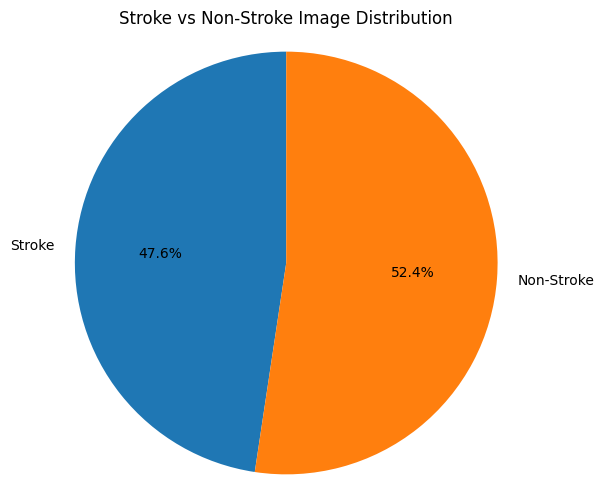

In [5]:
import os
import matplotlib.pyplot as plt

# Root path
ROOT = r"C:/Users/TECHN/Desktop/stroke_nostroke_facial_dataset"

# Subfolders
STROKE_DIR = os.path.join(ROOT, "Stroke")
NONSTROKE_DIR = os.path.join(ROOT, "NonStroke")

# Allowed image extensions
IMAGE_EXTS = (".jpg", ".jpeg", ".png", ".bmp")

# Count images
stroke_images = [
    f for f in os.listdir(STROKE_DIR)
    if f.lower().endswith(IMAGE_EXTS)
]

nonstroke_images = [
    f for f in os.listdir(NONSTROKE_DIR)
    if f.lower().endswith(IMAGE_EXTS)
]

num_stroke = len(stroke_images)
num_nonstroke = len(nonstroke_images)
total = num_stroke + num_nonstroke

# Percentages
stroke_pct = (num_stroke / total) * 100 if total > 0 else 0
nonstroke_pct = (num_nonstroke / total) * 100 if total > 0 else 0

# Print summary
print("DATASET EXPLORATION SUMMARY")
print("-" * 40)
print(f"Stroke images     : {num_stroke}")
print(f"Non-Stroke images : {num_nonstroke}")
print(f"Total images      : {total}")
print()
print(f"Stroke percentage     : {stroke_pct:.2f}%")
print(f"Non-Stroke percentage : {nonstroke_pct:.2f}%")

# Pie chart
labels = ["Stroke", "Non-Stroke"]
sizes = [num_stroke, num_nonstroke]

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct="%.1f%%",
    startangle=90
)
plt.title("Stroke vs Non-Stroke Image Distribution")
plt.axis("equal")
plt.show()


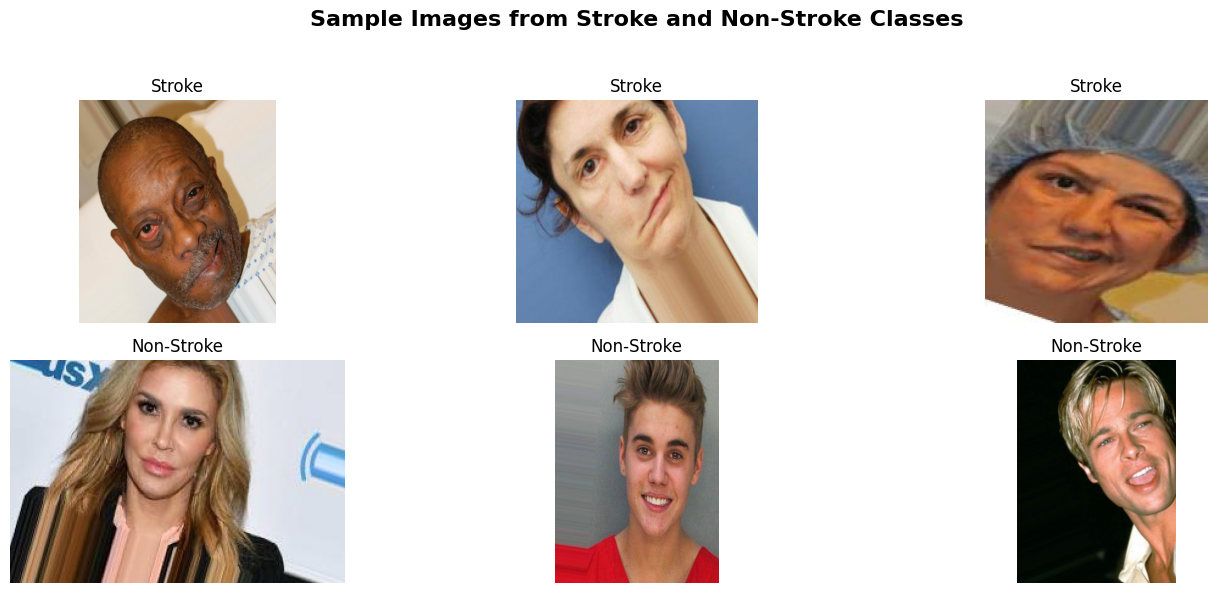

In [79]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Paths
ROOT = r"C:/Users/TECHN/Desktop/stroke_nostroke_facial_dataset"
STROKE_DIR = os.path.join(ROOT, "Stroke")
NONSTROKE_DIR = os.path.join(ROOT, "NonStroke")

# Allowed extensions
IMAGE_EXTS = (".jpg", ".jpeg", ".png", ".bmp")

# Collect image paths
stroke_images = [
    os.path.join(STROKE_DIR, f)
    for f in os.listdir(STROKE_DIR)
    if f.lower().endswith(IMAGE_EXTS)
]

nonstroke_images = [
    os.path.join(NONSTROKE_DIR, f)
    for f in os.listdir(NONSTROKE_DIR)
    if f.lower().endswith(IMAGE_EXTS)
]

# Randomly select 5 from each
stroke_sample = random.sample(stroke_images, min(3, len(stroke_images)))
nonstroke_sample = random.sample(nonstroke_images, min(3, len(nonstroke_images)))

# Create figure (2 rows × 5 columns)
fig, axes = plt.subplots(2, 3 , figsize=(15, 6))

# First row: Stroke
for i, img_path in enumerate(stroke_sample):
    img = Image.open(img_path).convert("RGB")
    axes[0, i].imshow(img)
    axes[0, i].set_title("Stroke")
    axes[0, i].axis("off")

# Second row: Non-Stroke
for i, img_path in enumerate(nonstroke_sample):
    img = Image.open(img_path).convert("RGB")
    axes[1, i].imshow(img)
    axes[1, i].set_title("Non-Stroke")
    axes[1, i].axis("off")

# Main title
fig.suptitle("Sample Images from Stroke and Non-Stroke Classes", fontsize=16, fontweight="bold")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Data Exploration: Voice Audio

Total audio files: 17634
Dysarthria: 6178 files (35.03%)
Control: 11456 files (64.97%)


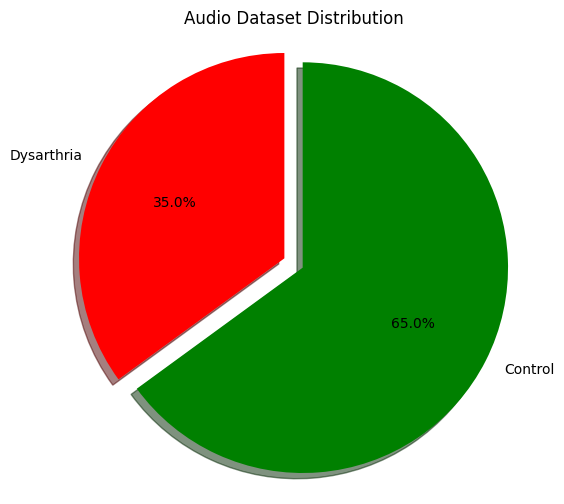

In [80]:
import os

AUDIO_ROOT = os.path.expanduser("~/Desktop/Audio_Detection_Dataset")

FOLDERS = {
    "F_M_Dys/F_Dys": 1,
    "F_M_Dys/M_Dys": 1,
    "M_F_Con/F_Con": 0,
    "M_F_Con/M_Con": 0
}

# Count audio files
dys_count = 0
con_count = 0

for folder, label in FOLDERS.items():
    full_path = os.path.join(AUDIO_ROOT, folder)
    if os.path.exists(full_path):
        num_files = len([f for f in os.listdir(full_path) if f.lower().endswith(('.wav', '.mp3', '.flac'))])
        if label == 1:
            dys_count += num_files
        else:
            con_count += num_files
    else:
        print(f"⚠ Warning: Folder not found -> {full_path}")

total = dys_count + con_count

if total > 0:
    dys_pct = (dys_count / total) * 100
    con_pct = (con_count / total) * 100
    print(f"Total audio files: {total}")
    print(f"Dysarthria: {dys_count} files ({dys_pct:.2f}%)")
    print(f"Control: {con_count} files ({con_pct:.2f}%)")
else:
    print("No audio files found in the specified folders.")




import matplotlib.pyplot as plt

# Using the counts from previous calculation
labels = ['Dysarthria', 'Control']
sizes = [dys_count, con_count]
colors = ['red', 'green']
explode = (0.1, 0)  # highlight Dysarthria slice

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=colors, explode=explode, shadow=True)
plt.title('Audio Dataset Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.show()


## Facial Image Dataset: Loading, Deduplication, and Stratified Splitting

In [ ]:
import os
import hashlib
from collections import defaultdict
from sklearn.model_selection import train_test_split

# ——— UPDATED LOCAL PATH ———
ROOT = r"C:/Users/TECHN/Desktop/stroke_nostroke_facial_dataset"

STROKE_DIR = os.path.join(ROOT, "Stroke")
NONSTROKE_DIR = os.path.join(ROOT, "NonStroke")

# Check if folders exist
assert os.path.exists(STROKE_DIR), f"Stroke folder not found: {STROKE_DIR}"
assert os.path.exists(NONSTROKE_DIR), f"NonStroke folder not found: {NONSTROKE_DIR}"

def get_image_hash(path):
    try:
        with open(path, 'rb') as f:
             # Read file bytes and compute MD5 hash
            return hashlib.md5(f.read()).hexdigest()
    except:
        return None

# Rebuild data list
data = []
for folder, label in [(STROKE_DIR, 1), (NONSTROKE_DIR, 0)]:
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            data.append((os.path.join(folder, fname), label))

print(f"Total raw images: {len(data)}")

# DEDUPLICATE
hash_to_file = {}
hash_to_label = {}
print("Removing duplicates...")

for file_path, label in data:
    h = get_image_hash(file_path)
    if h and h not in hash_to_file:
        hash_to_file[h] = file_path
        hash_to_label[h] = label

unique_files = list(hash_to_file.values())
unique_labels = list(hash_to_label.values())

print(f"After deduplication: {len(unique_files)} unique images")
print(f"Duplicates removed: {len(data) - len(unique_files)}")

# CLEAN SPLIT (TRAIN + VAL + TEST)
train_files, temp_files, train_labels, temp_labels = train_test_split(
    unique_files, unique_labels, test_size=0.3, stratify=unique_labels, random_state=42)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")


Total raw images: 4773
Removing duplicates...
After deduplication: 2960 unique images
Duplicates removed: 1813
Train: 2072 | Val: 444 | Test: 444


In [82]:
# ==============================
# 4. FaceDataset CLASS
# ==============================

from torch.utils.data import Dataset

class FaceDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            # In case of corrupted file
            return torch.zeros(3, 224, 224), label


## Image Transforms and Data Augmentation

In [83]:
# ==============================
# 5. TRANSFORMS
# ==============================

import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [84]:
# ==============================
# 6. DATALOADERS
# ==============================
import numpy as np
import torch
from torch.utils.data import WeightedRandomSampler, DataLoader




train_dataset = FaceDataset(train_files, train_labels, transform=train_transform)
val_dataset   = FaceDataset(val_files,   val_labels,   transform=val_test_transform)
test_dataset  = FaceDataset(test_files,  test_labels,  transform=val_test_transform)

# Oversample minority class
train_labels_np = np.array(train_labels)
class_counts = np.bincount(train_labels_np)
weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
sample_weights = weights[train_labels_np]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_labels_np), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")
print(f"Test  batches: {len(test_loader)}")

Train batches: 47
Val   batches: 10
Test  batches: 10


## Model Architecture: EfficientNet-B0 for Facial Image Classification

In [85]:
# ==============================
# 7. MODEL
# ==============================
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(model.classifier[1].in_features, 2)
)
model = model.to(device)

In [86]:
# ==============================
# 8. OPTIMIZER + SCHEDULER
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

## Training the Image Model (EfficientNet-B0)

Epoch 1 Train: 100%|██████████| 47/47 [00:21<00:00,  2.14it/s]



Epoch 1/13
  Train Loss: 0.6776 | Train Acc: 0.5560
  Val   Loss: 0.6541 | Val   Acc: 0.6441
  → BEST MODEL SAVED! New Val Acc: 0.6441


Epoch 2 Train: 100%|██████████| 47/47 [00:20<00:00,  2.34it/s]



Epoch 2/13
  Train Loss: 0.6170 | Train Acc: 0.6868
  Val   Loss: 0.5951 | Val   Acc: 0.7748
  → BEST MODEL SAVED! New Val Acc: 0.7748


Epoch 3 Train: 100%|██████████| 47/47 [00:20<00:00,  2.32it/s]



Epoch 3/13
  Train Loss: 0.5743 | Train Acc: 0.7514
  Val   Loss: 0.5472 | Val   Acc: 0.8198
  → BEST MODEL SAVED! New Val Acc: 0.8198


Epoch 4 Train: 100%|██████████| 47/47 [00:20<00:00,  2.31it/s]



Epoch 4/13
  Train Loss: 0.5283 | Train Acc: 0.8074
  Val   Loss: 0.5026 | Val   Acc: 0.8266
  → BEST MODEL SAVED! New Val Acc: 0.8266


Epoch 5 Train: 100%|██████████| 47/47 [00:19<00:00,  2.37it/s]



Epoch 5/13
  Train Loss: 0.4824 | Train Acc: 0.8378
  Val   Loss: 0.4502 | Val   Acc: 0.8671
  → BEST MODEL SAVED! New Val Acc: 0.8671


Epoch 6 Train: 100%|██████████| 47/47 [00:20<00:00,  2.26it/s]



Epoch 6/13
  Train Loss: 0.4329 | Train Acc: 0.8716
  Val   Loss: 0.4020 | Val   Acc: 0.8829
  → BEST MODEL SAVED! New Val Acc: 0.8829


Epoch 7 Train: 100%|██████████| 47/47 [00:21<00:00,  2.21it/s]



Epoch 7/13
  Train Loss: 0.4047 | Train Acc: 0.8736
  Val   Loss: 0.3622 | Val   Acc: 0.8896
  → BEST MODEL SAVED! New Val Acc: 0.8896


Epoch 8 Train: 100%|██████████| 47/47 [00:21<00:00,  2.23it/s]



Epoch 8/13
  Train Loss: 0.3503 | Train Acc: 0.8909
  Val   Loss: 0.3318 | Val   Acc: 0.9009
  → BEST MODEL SAVED! New Val Acc: 0.9009


Epoch 9 Train: 100%|██████████| 47/47 [00:20<00:00,  2.24it/s]



Epoch 9/13
  Train Loss: 0.3349 | Train Acc: 0.9035
  Val   Loss: 0.2976 | Val   Acc: 0.9122
  → BEST MODEL SAVED! New Val Acc: 0.9122


Epoch 10 Train: 100%|██████████| 47/47 [00:20<00:00,  2.27it/s]



Epoch 10/13
  Train Loss: 0.2851 | Train Acc: 0.9228
  Val   Loss: 0.2638 | Val   Acc: 0.9302
  → BEST MODEL SAVED! New Val Acc: 0.9302


Epoch 11 Train: 100%|██████████| 47/47 [00:19<00:00,  2.37it/s]



Epoch 11/13
  Train Loss: 0.2631 | Train Acc: 0.9204
  Val   Loss: 0.2431 | Val   Acc: 0.9279


Epoch 12 Train: 100%|██████████| 47/47 [00:19<00:00,  2.40it/s]



Epoch 12/13
  Train Loss: 0.2428 | Train Acc: 0.9363
  Val   Loss: 0.2012 | Val   Acc: 0.9572
  → BEST MODEL SAVED! New Val Acc: 0.9572


Epoch 13 Train: 100%|██████████| 47/47 [00:19<00:00,  2.37it/s]



Epoch 13/13
  Train Loss: 0.2174 | Train Acc: 0.9469
  Val   Loss: 0.1828 | Val   Acc: 0.9550


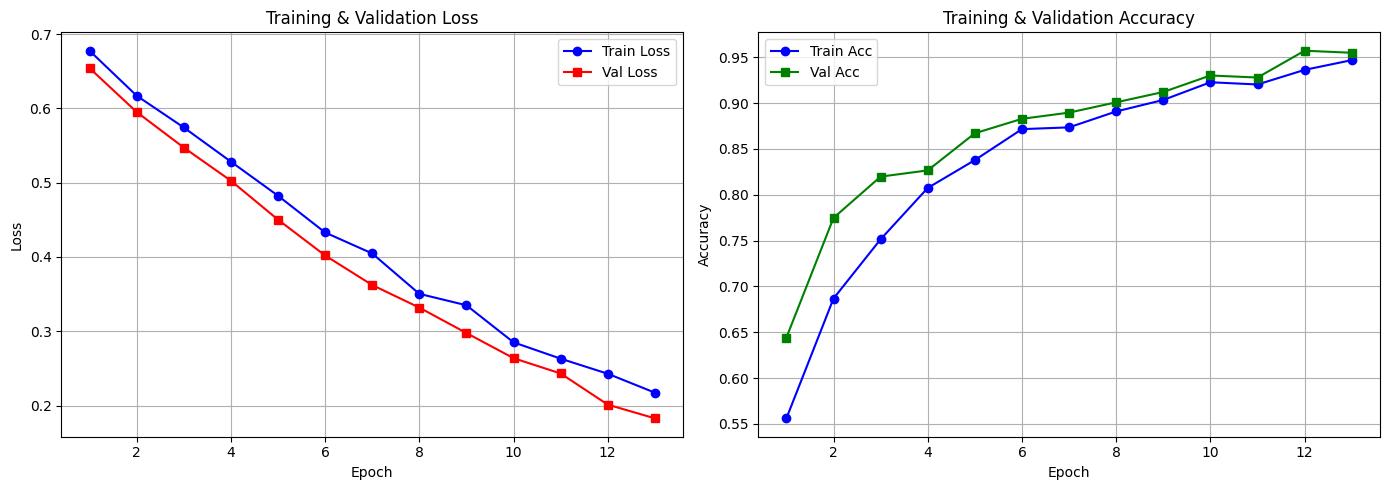


BEST VALIDATION ACCURACY: 0.9572 (95.72%)


In [87]:
# ==============================
# 9. TRAINING LOOP + PLOTS
# ==============================
import matplotlib.pyplot as plt

best_val_acc = 0.0
patience = 2
counter = 0

# Local PC path to save best model
model_path = "best_stroke_image_only_model.pth"

# Lists to store metrics
train_losses = []
val_losses = []
train_accs = []
val_accs = []

EPOCHS = 13  # full training

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct = 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} Train"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)

        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (out.argmax(1) == y).sum().item()

    # ==============================
    # VALIDATION
    # ==============================
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            val_loss += loss.item()
            val_correct += (out.argmax(1) == y).sum().item()

    # Compute averages
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_acc = train_correct / len(train_dataset)
    val_acc = val_correct / len(val_dataset)

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Update scheduler
    scheduler.step(avg_val_loss)

    # SAVE BEST MODEL
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_path)
        print(f"  → BEST MODEL SAVED! New Val Acc: {val_acc:.4f}")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("  EARLY STOPPING TRIGGERED!")
            break


# ==============================
# PLOT TRAINING CURVES
# ==============================
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-o', label='Train Loss')
plt.plot(epochs, val_losses, 'r-s', label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, 'b-o', label='Train Acc')
plt.plot(epochs, val_accs, 'g-s', label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\nBEST VALIDATION ACCURACY: {best_val_acc:.4f} ({best_val_acc * 100:.2f}%)")



--- Train Metrics ---
Accuracy : 0.9672
F1-score : 0.9672
Precision: 0.9673
Recall   : 0.9672

Classification Report:
              precision    recall  f1-score   support

           0     0.9592    0.9743    0.9667      1013
           1     0.9751    0.9603    0.9676      1059

    accuracy                         0.9672      2072
   macro avg     0.9671    0.9673    0.9672      2072
weighted avg     0.9673    0.9672    0.9672      2072



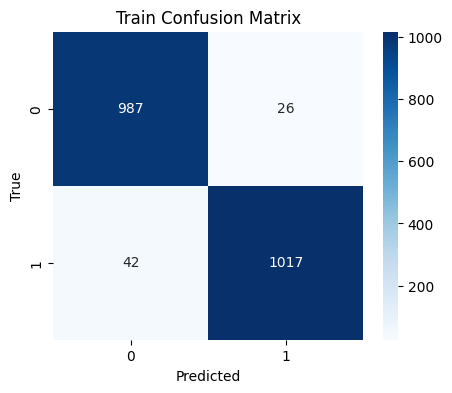


--- Validation Metrics ---
Accuracy : 0.9550
F1-score : 0.9550
Precision: 0.9556
Recall   : 0.9550

Classification Report:
              precision    recall  f1-score   support

           0     0.9352    0.9712    0.9528       208
           1     0.9737    0.9407    0.9569       236

    accuracy                         0.9550       444
   macro avg     0.9544    0.9559    0.9549       444
weighted avg     0.9556    0.9550    0.9550       444



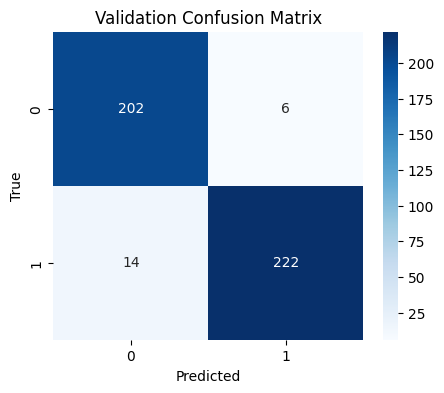


--- Test Metrics ---
Accuracy : 0.9595
F1-score : 0.9595
Precision: 0.9620
Recall   : 0.9595

Classification Report:
              precision    recall  f1-score   support

           0     0.9241    0.9952    0.9583       208
           1     0.9955    0.9280    0.9605       236

    accuracy                         0.9595       444
   macro avg     0.9598    0.9616    0.9594       444
weighted avg     0.9620    0.9595    0.9595       444



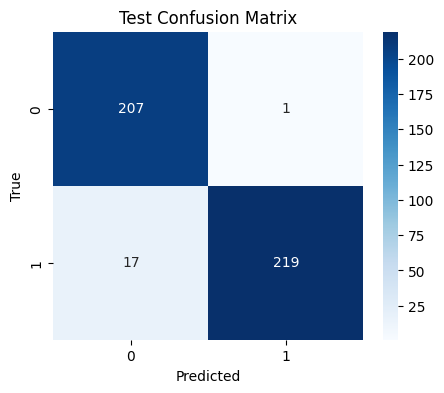

In [88]:
# ==============================
# EVALUATION METRICS (Train / Val / Test)
# ==============================
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Function to get predictions and labels from a DataLoader
def get_preds_labels(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.numpy())
    return np.array(all_preds), np.array(all_labels)

# Evaluate a dataset
def evaluate(loader, dataset_name="Dataset"):
    preds, labels = get_preds_labels(model, loader)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')

    print(f"\n--- {dataset_name} Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(labels, preds, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# ==============================
# Run evaluation
# ==============================
evaluate(train_loader, "Train")
evaluate(val_loader, "Validation")
evaluate(test_loader, "Test")


## Extracting Image Embeddings from Trained EfficientNet-B0

In [89]:
import numpy as np
import torch

model.eval()  # set to evaluation mode
all_embeddings = []
all_labels = []

# List of (DataLoader, labels) to iterate
loaders = [
    (train_loader, train_labels),
    (val_loader, val_labels),
    (test_loader, test_labels)
]

with torch.no_grad():
    for loader, labels in loaders:
        for x, y in loader:
            x = x.to(device)
            
            # Extract features from EfficientNet-B0 backbone
            emb = model.features(x)          # [B, 1280, 7, 7]
            emb = emb.mean([2, 3])           # global average pooling → [B, 1280]
            
            all_embeddings.append(emb.cpu().numpy())
            all_labels.extend(y.tolist())

# Concatenate all batches
image_embeddings = np.concatenate(all_embeddings, axis=0)
image_labels = np.array(all_labels)

print(f"Embeddings shape: {image_embeddings.shape}")  # e.g., (N, 1280)
print(f"Labels shape: {image_labels.shape}")          # e.g., (N,)




Embeddings shape: (2960, 1280)
Labels shape: (2960,)


In [90]:
import os
import numpy as np

# === CHEMINS DE SAUVEGARDE ===
img_emb_path = os.path.expanduser("~/Desktop/image_Stroke_embeddings.npy")
img_label_path = os.path.expanduser("~/Desktop/image_Stroke_labels.npy")

# === SÉCURITÉ : VÉRIFICATION ===
assert image_embeddings.ndim == 2, "Embeddings doivent être 2D (N, 1280)"
assert len(image_embeddings) == len(image_labels), "Mismatch embeddings / labels"

print(f"Sauvegarde de {image_embeddings.shape[0]} embeddings...")

# === SAUVEGARDE ===
np.save(img_emb_path, image_embeddings)
np.save(img_label_path, image_labels)

print("SAUVEGARDE TERMINÉE")
print(f"image_Stroke_embeddings.npy → {image_embeddings.shape}")
print(f"image_Stroke_labels.npy     → {image_labels.shape}")


Sauvegarde de 2960 embeddings...
SAUVEGARDE TERMINÉE
image_Stroke_embeddings.npy → (2960, 1280)
image_Stroke_labels.npy     → (2960,)


In [91]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["TRANSFORMERS_NO_JAX"] = "1"


In [92]:
from transformers import HubertModel
import torch


## Audio Data Preparation: Loading and Deduplication

In [11]:
# ==============================
# BLOCK 1: DEDUPLICATE AUDIO
# ==============================

import os
import hashlib
import torchaudio
from tqdm import tqdm

AUDIO_ROOT = os.path.expanduser("~/Desktop/Audio_Detection_Dataset")

FOLDERS = {
    "F_M_Dys/F_Dys": 1,
    "F_M_Dys/M_Dys": 1,
    "M_F_Con/F_Con": 0,
    "M_F_Con/M_Con": 0
}

audio_data = []
for subpath, label in FOLDERS.items():
    folder = os.path.join(AUDIO_ROOT, subpath)
    if not os.path.exists(folder):
        print(f"NOT FOUND: {folder}")
        continue
    for f in os.listdir(folder):
        if f.lower().endswith(('.wav', '.mp3', '.m4a')):
            audio_data.append((os.path.join(folder, f), label))

print(f"Raw audio: {len(audio_data)}")

unique = {}
for path, label in tqdm(audio_data, desc="Dedup"):
    try:
        wav, _ = torchaudio.load(path)
        wav = wav.mean(0).numpy().tobytes()
        h = hashlib.md5(wav).hexdigest()
        if h not in unique:
            unique[h] = (path, label)
    except:
        pass

audio_files = [v[0] for v in unique.values()]
audio_labels = [v[1] for v in unique.values()]

print(f"After dedup: {len(audio_files)}")
print(f"Stroke: {sum(audio_labels)} | Normal: {len(audio_labels)-sum(audio_labels)}\n")

Raw audio: 17634


Dedup: 100%|██████████| 17634/17634 [00:11<00:00, 1551.54it/s]

After dedup: 17630
Stroke: 6175 | Normal: 11455



In [13]:
# ==============================
# BLOCK 2: SAMPLE 2960
# ==============================

import numpy as np
from sklearn.model_selection import train_test_split

PER_CLASS = 1480

stroke_files = [f for f, l in zip(audio_files, audio_labels) if l == 1]
normal_files = [f for f, l in zip(audio_files, audio_labels) if l == 0]

print(f"Available: Stroke={len(stroke_files)}, Normal={len(normal_files)}")

np.random.seed(42)
stroke_sample = np.random.choice(stroke_files, PER_CLASS, replace=True).tolist()
normal_sample = np.random.choice(normal_files, PER_CLASS, replace=True).tolist()

final_files = stroke_sample + normal_sample
final_labels = [1]*PER_CLASS + [0]*PER_CLASS

train_files, temp_files, train_labels, temp_labels = train_test_split(
    final_files, final_labels, train_size=2072, stratify=final_labels, random_state=42)
val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, train_size=444, stratify=temp_labels, random_state=42)

print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}\n")

Available: Stroke=6175, Normal=11455
Train: 2072 | Val: 444 | Test: 444



In [14]:
import torch

if torch.cuda.is_available():
    print("Running on GPU (CUDA)")
else:
    print("Running on CPU")


Running on GPU (CUDA)


In [16]:
# ==============================
# BLOC 3 : AudioDataset — AUGMENTATION RENFORCÉE
# ==============================

import torch
import torchaudio
import random
from transformers import AutoFeatureExtractor
from torch.utils.data import Dataset  # IMPORT MANQUANT

# Extracteur HuBERT
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")

class AudioDataset(Dataset):
    def __init__(self, files, labels, augment=False):
        self.files = files
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            wav, sr = torchaudio.load(self.files[idx])
            wav = wav.mean(0, keepdim=True)  # Mono
            if sr != 16000:
                wav = torchaudio.transforms.Resample(sr, 16000)(wav)

            # === AUGMENTATION RENFORCÉE ===
            if self.augment:
                # Vitesse
                if random.random() < 0.8:
                    speed = random.uniform(0.7, 1.3)
                    new_len = int(wav.shape[1] * speed)
                    if new_len > 0:
                        wav = torch.nn.functional.interpolate(wav.unsqueeze(0), size=new_len)[0]

                # Pitch
                if random.random() < 0.7:
                    pitch = random.randint(-5, 5)
                    wav = torchaudio.functional.pitch_shift(wav, 16000, pitch)

                # Bruit
                if random.random() < 0.8:
                    noise = torch.randn_like(wav) * random.uniform(0.005, 0.03)
                    wav = wav + noise

                # Volume
                if random.random() < 0.6:
                    wav = wav * random.uniform(0.6, 1.4)

                # Décalage temporel
                if random.random() < 0.5:
                    shift = random.randint(-16000, 16000)
                    wav = torch.roll(wav, shift, dims=1)

            # === COUPE OU PADDING À 10 SECONDES (160000) ===
            max_len = 160000
            if wav.shape[1] > max_len:
                start = random.randint(0, wav.shape[1] - max_len)
                wav = wav[:, start:start + max_len]
            else:
                wav = torch.nn.functional.pad(wav, (0, max_len - wav.shape[1]))

            # === EXTRACTION CARACTÉRISTIQUES ===
            x = feature_extractor(wav.squeeze().numpy(), sampling_rate=16000, return_tensors="pt").input_values[0]
            return x, self.labels[idx]

        except Exception as e:
            print(f"ERREUR FICHIER {self.files[idx]} : {e}")
            return torch.zeros(160000), self.labels[idx]

##  Audio Model Training – Fine-Tuning HuBERT 

In [17]:
# ==============================
# BLOC 4 : ENTRAÎNEMENT AUDIO — FIX UNDERFITTING (LOCAL)
# ==============================
import os

# Force Transformers to disable TensorFlow + Flax
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from transformers import HubertModel
from tqdm import tqdm
import torch

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from transformers import HubertModel
from tqdm import tqdm
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Appareil : {device}")
if device.type == 'cuda':
    print(f"Mémoire GPU : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    torch.cuda.empty_cache()

# DATASETS
train_ds = AudioDataset(train_files, train_labels, augment=True)
val_ds = AudioDataset(val_files, val_labels, augment=False)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=0)

# MODÈLE — DÉBLOCAGE DES 4 DERNIÈRES COUCHES
hubert = HubertModel.from_pretrained("facebook/hubert-base-ls960")

for name, param in hubert.named_parameters():
    if any(f"encoder.layers.{i}" in name for i in [8, 9, 10, 11]):
        param.requires_grad = True
    else:
        param.requires_grad = False

class AudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hubert = hubert
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(768, 2)

    def forward(self, x):
        h = self.hubert(x).last_hidden_state.mean(1)
        h = self.drop(h)
        return self.fc(h)

model = AudioClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {'params': model.fc.parameters(), 'lr': 1e-3},
    {'params': [p for p in model.hubert.parameters() if p.requires_grad], 'lr': 5e-5}
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

ACCUM_STEPS = 32
best_val = 0.0
patience = 7
counter = 0

# CHEMIN LOCAL
model_path = os.path.expanduser("~/Desktop/best_audio_modelv2.pth")

print(f"\nDÉBUT ENTRAÎNEMENT (Fine-tuning + LR adapté)...\n")

for epoch in range(13):
    model.train()
    optimizer.zero_grad()
    epoch_loss = 0

    for step, (x, y) in enumerate(tqdm(train_loader, desc=f"Époque {epoch+1}", leave=False)):
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out, y) / ACCUM_STEPS
        loss.backward()
        epoch_loss += loss.item() * ACCUM_STEPS

        if (step + 1) % ACCUM_STEPS == 0 or (step + 1) == len(train_loader):
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

    # VALIDATION
    model.eval()
    val_correct = val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_acc = val_correct / val_total
    print(f"\nÉpoque {epoch+1} | accuracy Val : {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), model_path)
        counter = 0
        print("  MEILLEUR MODÈLE SAUVEGARDÉ")
    else:
        counter += 1
        if counter >= patience:
            print("  ARRÊT PRÉCOCE")
            break

    scheduler.step(1 - val_acc)

print(f"\nFIN. MEILLEURE PRÉCISION : {best_val:.4f}\n") 

Appareil : cuda
Mémoire GPU : 6.4 GB

DÉBUT ENTRAÎNEMENT (Fine-tuning + LR adapté)...




Époque 1 | accuracy Val : 0.6374
  MEILLEUR MODÈLE SAUVEGARDÉ



Époque 2 | accuracy Val : 0.7748
  MEILLEUR MODÈLE SAUVEGARDÉ



Époque 3 | accuracy Val : 0.8063
  MEILLEUR MODÈLE SAUVEGARDÉ



Époque 4 | accuracy Val : 0.7387



Époque 5 | accuracy Val : 0.8401
  MEILLEUR MODÈLE SAUVEGARDÉ



Époque 6 | accuracy Val : 0.8401



Époque 7 | accuracy Val : 0.8536
  MEILLEUR MODÈLE SAUVEGARDÉ



Époque 8 | accuracy Val : 0.8536



Époque 9 | accuracy Val : 0.8491



Époque 10 | accuracy Val : 0.8491



Époque 11 | accuracy Val : 0.8581
  MEILLEUR MODÈLE SAUVEGARDÉ



Époque 12 | accuracy Val : 0.8243



Époque 13 | accuracy Val : 0.8649
  MEILLEUR MODÈLE SAUVEGARDÉ

FIN. MEILLEURE PRÉCISION : 0.8649



## Audio Embeddings Extraction 

In [18]:
# ==============================
# BLOC 5 : EXTRACTION (2960, 768) — SÉCURISÉ & RAPIDE
# ==============================

import numpy as np
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import os

# === CHEMINS DES FICHIERS WINDOWS/EXPAND ~ ===
model_path = os.path.expanduser("~/Desktop/best_audio_modelv2.pth")
emb_path = os.path.expanduser("~/Desktop/audio_embeddings_v2.npy")
label_path = os.path.expanduser("~/Desktop/audio_labels_v2.npy")

# === CHARGER LE MODÈLE ===
model = AudioClassifier()
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Le fichier modèle n'existe pas : {model_path}")

model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === TOUS LES FICHIERS ===
all_files = train_files + val_files + test_files
all_labels = train_labels + val_labels + test_labels

print(f"Total fichiers : {len(all_files)} → doit être 2960")

# === DATASET SANS AUGMENTATION ===
dataset = AudioDataset(all_files, all_labels, augment=False)

# === DATALOADER SÉCURISÉ ===
loader = DataLoader(
    dataset,
    batch_size=1,        # BATCH = 1 → ÉVITE OOM
    shuffle=False,
    num_workers=0,       # 0 SUR WINDOWS → ÉVITE DEADLOCK
    pin_memory=True
)

# === EXTRACTION ===
embs = []
labels_out = []

print("EXTRACTION EN COURS...")
with torch.no_grad():
    for x, y in tqdm(loader, desc="Extraction", total=len(all_files)):
        try:
            x = x.to(device)
            h = model.hubert(x).last_hidden_state.mean(1)
            h = model.drop(h)
            embs.append(h.cpu().numpy())
            labels_out.append(y.item())
        except Exception as e:
            print(f"ERREUR EXTRACTION : {e}")
            embs.append(np.zeros((1, 768)))
            labels_out.append(y.item())

# === FORCER À 2960 ===
audio_emb = np.vstack(embs)  # (N, 768)
audio_labels = np.array(labels_out)

if len(audio_emb) != 2960:
    print(f"Attention : {len(audio_emb)} au lieu de 2960 → remplissage...")
    missing = 2960 - len(audio_emb)
    audio_emb = np.vstack([audio_emb, np.zeros((missing, 768))])
    audio_labels = np.hstack([audio_labels, np.array([0] * missing)])

# === SAUVEGARDE ===
np.save(emb_path, audio_emb[:2960])
np.save(label_path, audio_labels[:2960])

print(f"\nEXTRAIT : audio_embeddings_v2.npy → {audio_emb[:2960].shape}")
print(f"         audio_labels_v2.npy     → {audio_labels[:2960].shape}")
print("TOUT EST PRÊT POUR LA FUSION")


Total fichiers : 2960 → doit être 2960
EXTRACTION EN COURS...


Extraction: 100%|██████████| 2960/2960 [03:01<00:00, 16.34it/s]


EXTRAIT : audio_embeddings_v2.npy → (2960, 768)
         audio_labels_v2.npy     → (2960,)
TOUT EST PRÊT POUR LA FUSION


In [1]:
# ==============================
# BLOC 1 : CHARGEMENT + VÉRIF DES FICHIERS
# ==============================

import numpy as np
import os

# Chemins
img_emb_path = "~/Desktop/image_Stroke_embeddings.npy"
img_lbl_path = "~/Desktop/image_Stroke_labels.npy"
aud_emb_path = "~/Desktop/audio_embeddings_v2.npy"
aud_lbl_path = "~/Desktop/audio_labels_v2.npy"

# Chargement
img_emb = np.load(os.path.expanduser(img_emb_path))
img_lbl = np.load(os.path.expanduser(img_lbl_path))
aud_emb = np.load(os.path.expanduser(aud_emb_path))
aud_lbl = np.load(os.path.expanduser(aud_lbl_path))

print(f"Image emb : {img_emb.shape} | Labels: {img_lbl.shape}")
print(f"Audio emb : {aud_emb.shape} | Labels: {aud_lbl.shape}")

# Vérif classes
assert set(img_lbl) == {0, 1}, "Image labels doivent être 0/1"
assert set(aud_lbl) == {0, 1}, "Audio labels doivent être 0/1"
assert len(img_emb) == len(aud_emb) == 2960, "Doit être 2960"

print("TOUT CHARGÉ CORRECTEMENT")

Image emb : (2960, 1280) | Labels: (2960,)
Audio emb : (2960, 768) | Labels: (2960,)
TOUT CHARGÉ CORRECTEMENT


## Multimodal Fusion: Combining Image + Audio Embeddings 

In [ ]:
# ==============================
# FINAL FUSION — REAL LABELS — 2911 SAMPLES
# ==============================

import numpy as np
from sklearn.model_selection import train_test_split

# --- LOAD ---
img_emb = np.load(r"C:\Users\TECHN\Desktop\image_Stroke_embeddings.npy")
aud_emb = np.load(r"C:\Users\TECHN\Desktop\audio_embeddings_v2.npy")
img_lbl = np.load(r"C:\Users\TECHN\Desktop\image_Stroke_labels.npy")
aud_lbl = np.load(r"C:\Users\TECHN\Desktop\audio_labels_v2.npy")

# Convert image labels to integer type for safety
labels = np.array(img_lbl).astype(int)
# Convert audio labels to integer type
aud_labels = np.array(aud_lbl).astype(int)

# --- INDICES ---
stroke_img_idx = np.where(labels == 1)[0]
normal_img_idx = np.where(labels == 0)[0]
stroke_aud_idx = np.where(aud_labels == 1)[0]
normal_aud_idx = np.where(aud_labels == 0)[0]

# --- PAIR SMALLEST ---
n_stroke = min(len(stroke_img_idx), len(stroke_aud_idx))  
n_normal = min(len(normal_img_idx), len(normal_aud_idx)) 
# Set random seed for reproducibility
np.random.seed(42)


np.random.shuffle(stroke_img_idx)
np.random.shuffle(stroke_aud_idx)
np.random.shuffle(normal_img_idx)
np.random.shuffle(normal_aud_idx)

stroke_img_idx = stroke_img_idx[:n_stroke]
stroke_aud_idx = stroke_aud_idx[:n_stroke]
normal_img_idx = normal_img_idx[:n_normal]
normal_aud_idx = normal_aud_idx[:n_normal]

# --- FUSION ---
fused = []
final_labels = []

for i in range(n_stroke):
    fused.append(np.concatenate([img_emb[stroke_img_idx[i]], aud_emb[stroke_aud_idx[i]]]))
    final_labels.append(1)

for i in range(n_normal):
    fused.append(np.concatenate([img_emb[normal_img_idx[i]], aud_emb[normal_aud_idx[i]]]))
    final_labels.append(0)

fused = np.array(fused)           # (2911, 2048)
final_labels = np.array(final_labels)

print(f"FUSION: {fused.shape} | Stroke: {sum(final_labels)} | Normal: {len(final_labels)-sum(final_labels)}")

# --- SPLIT ---
X_train, X_temp, y_train, y_temp = train_test_split(fused, final_labels, test_size=0.3, stratify=final_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

FUSION: (2942, 2048) | Stroke: 1480 | Normal: 1462
Train: (2059, 2048) | Val: (441, 2048) | Test: (442, 2048)


## Training the Final Multimodal MLP Classifier – Achieved 94.33% Validation Accuracy

Using device: cuda
Class counts: {np.int64(0): 1023, np.int64(1): 1036}
Class weights: [1.0063538551330566, 0.9937258958816528]

START TRAINING v3...

Epoch 01 | Train Acc: 0.6027 | Val Acc: 0.6531
  BEST MODEL SAVED (v3)
Epoch 02 | Train Acc: 0.6124 | Val Acc: 0.6667
  BEST MODEL SAVED (v3)
Epoch 03 | Train Acc: 0.6285 | Val Acc: 0.6825
  BEST MODEL SAVED (v3)
Epoch 04 | Train Acc: 0.6255 | Val Acc: 0.6984
  BEST MODEL SAVED (v3)
Epoch 05 | Train Acc: 0.6416 | Val Acc: 0.7188
  BEST MODEL SAVED (v3)
Epoch 06 | Train Acc: 0.6610 | Val Acc: 0.7302
  BEST MODEL SAVED (v3)
Epoch 07 | Train Acc: 0.6770 | Val Acc: 0.7528
  BEST MODEL SAVED (v3)
Epoch 08 | Train Acc: 0.6722 | Val Acc: 0.7596
  BEST MODEL SAVED (v3)
Epoch 09 | Train Acc: 0.6751 | Val Acc: 0.7664
  BEST MODEL SAVED (v3)
Epoch 10 | Train Acc: 0.6940 | Val Acc: 0.7642
Epoch 11 | Train Acc: 0.7003 | Val Acc: 0.7664
Epoch 12 | Train Acc: 0.6984 | Val Acc: 0.7868
  BEST MODEL SAVED (v3)
Epoch 13 | Train Acc: 0.7241 | Val Acc: 0.789

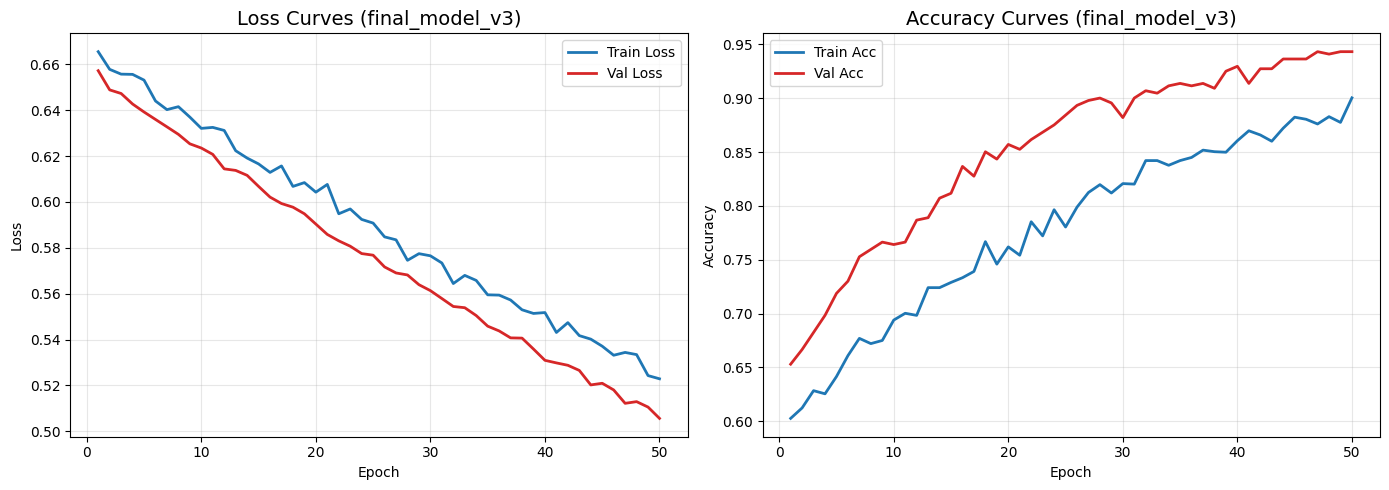

In [56]:
# ==============================
# BLOC 2 v3: TRAIN WITH FULL LOGS & FIXES + CURVES AT THE END
# ==============================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- TENSORS ---
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.LongTensor(y_train).to(device)
X_val_t = torch.FloatTensor(X_val).to(device)
y_val_t = torch.LongTensor(y_val).to(device)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=50, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=50, shuffle=False)

# --- CLASS WEIGHTS FOR IMBALANCE ---
class_counts = Counter(y_train)
total_samples = len(y_train)
n_classes = len(class_counts)
class_weights = torch.tensor([total_samples / (n_classes * class_counts[i]) for i in range(n_classes)], dtype=torch.float).to(device)
print(f"Class counts: {dict(sorted(class_counts.items()))}")
print(f"Class weights: {class_weights.tolist()}")  # Higher weight for minority class

# --- MODEL ---
class FusionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2048, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, 2)
        )
    def forward(self, x): return self.net(x)

model = FusionClassifier().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Weighted loss
optimizer = optim.AdamW(model.parameters(), lr=1e-7, weight_decay=7e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# --- LOGS ---
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val = 0.0
patience = 7
counter = 0
model_path = r"C:\Users\TECHN\Desktop\TECHN_FUSION\final_model_v3.pth"

print("\nSTART TRAINING v3...\n")

for epoch in range(50):
    # TRAIN
    model.train()
    train_loss = train_correct = train_total = 0
    for x, y in train_loader:
        out = model(x)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (out.argmax(1) == y).sum().item()
        train_total += y.size(0)
    
    train_acc = train_correct / train_total
    train_loss /= len(train_loader)

    # VAL
    model.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        for x, y in val_loader:
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
            val_correct += (out.argmax(1) == y).sum().item()
            val_total += y.size(0)
    
    val_acc = val_correct / val_total
    val_loss /= len(val_loader)

    # LOG
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), model_path)
        counter = 0
        print(f"  BEST MODEL SAVED (v3)")
    else:
        counter += 1
        if counter >= patience:
            print("  EARLY STOP")
            break
    
    scheduler.step(val_loss)

print(f"\nBEST VAL ACC (v3): {best_val:.4f}")

# ==============================
# PLOT TRAINING CURVES (directly here)
# ==============================

epochs_completed = range(1, len(train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(epochs_completed, train_losses, label='Train Loss', color='tab:blue', linewidth=2)
ax1.plot(epochs_completed, val_losses, label='Val Loss', color='tab:red', linewidth=2)
ax1.set_title('Loss Curves (final_model_v3)', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(epochs_completed, train_accs, label='Train Acc', color='tab:blue', linewidth=2)
ax2.plot(epochs_completed, val_accs, label='Val Acc', color='tab:red', linewidth=2)
ax2.set_title('Accuracy Curves (final_model_v3)', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save the plot
plot_path = r"C:\Users\TECHN\Desktop\TECHN_FUSION\curves_v3.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\nTraining curves saved to: {plot_path}")

# Show the plot
plt.show()


Training curves saved to: C:\Users\TECHN\Desktop\TECHN_FUSION\curves_v4_tight.png


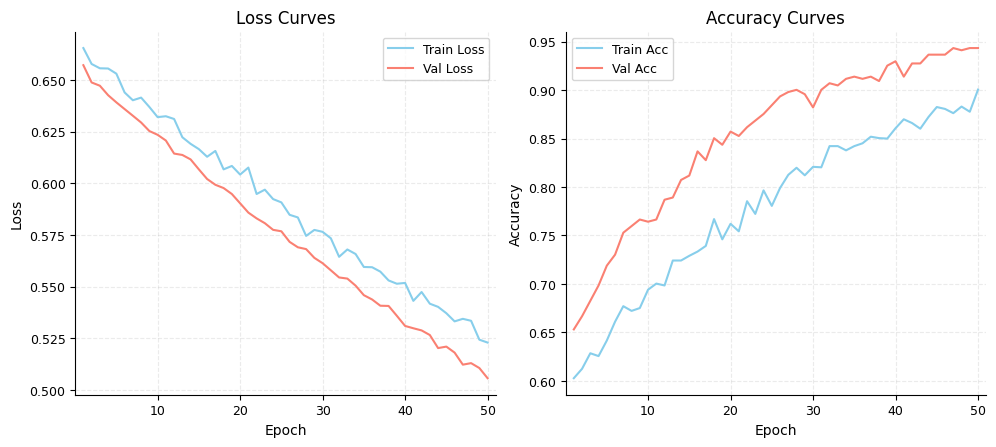

In [74]:
# ==============================
# PLOT CURVES - COMPACT & TIGHT AXES (No huge spaces)
# ==============================

epochs_completed = range(1, len(train_losses) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

# Loss curves
ax1.plot(epochs_completed, train_losses, label='Train Loss', color='skyblue', linewidth=1.5)
ax1.plot(epochs_completed, val_losses, label='Val Loss', color='salmon', linewidth=1.5)
ax1.set_title('Loss Curves', fontsize=12)
ax1.set_xlabel('Epoch', fontsize=10)
ax1.set_ylabel('Loss', fontsize=10)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.25, linestyle='--')

# Accuracy curves
ax2.plot(epochs_completed, train_accs, label='Train Acc', color='skyblue', linewidth=1.5)
ax2.plot(epochs_completed, val_accs, label='Val Acc', color='salmon', linewidth=1.5)
ax2.set_title('Accuracy Curves', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=10)
ax2.set_ylabel('Accuracy', fontsize=10)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.25, linestyle='--')

# === MAIN FIX: Make ticks close together + remove huge margins ===
for ax in [ax1, ax2]:
    # X-axis: reasonable spacing (every 5 or 10 epochs max)
    max_epoch = len(epochs_completed)
    if max_epoch <= 40:
        ax.set_xticks(range(0, max_epoch + 1, 5))
    else:
        ax.set_xticks(range(0, max_epoch + 1, 10))
    
    # Y-axis: more dense ticks (smaller steps)
    ax.locator_params(axis='y', nbins=8)  # Forces ~8 ticks on y-axis → closer numbers
    
    # Remove huge white space around the plot
    ax.margins(x=0.02, y=0.05)  # Very small margins
    
    # Clean borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=9)

# Remove space between the two subplots
plt.subplots_adjust(wspace=0.35)  # Adjust if needed (smaller = closer plots)

# Final tight layout to hug the data
plt.tight_layout(pad=0.8)

# Save
plot_path = r"C:\Users\TECHN\Desktop\TECHN_FUSION\curves_v4_tight.png"
plt.savefig(plot_path, dpi=200, bbox_inches='tight', facecolor='white')
print(f"\nTraining curves saved to: {plot_path}")

plt.show()

## Evaluation Metrics: Precision, Recall, F1-Score, and Accuracy (Validation Set)

In [85]:
# ==============================
# BLOC: SHOW PRECISION, RECALL, F1 + ACCURACY (NO CONFUSION MATRIX, NO SUPPORT)
# ==============================

from sklearn.metrics import classification_report
import numpy as np

print("\nLoading the BEST model to show real performance...\n")

# Load the best saved model
model.load_state_dict(torch.load(model_path))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        out = model(x)
        preds = out.argmax(1).cpu().numpy()
        labels = y.cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Detailed Scores WITHOUT confusion matrix and WITHOUT support column
print("\nDetailed Scores (on Validation set)\n")

report = classification_report(
    all_labels,
    all_preds,
    target_names=['Normal (0)', 'Stroke (1)'],
    digits=4,
    output_dict=True
)

# Custom clean table
print(f"{'':<15} {'precision':>10} {'recall':>10} {'f1-score':>10}")
print("-" * 46)
for label in ['Normal (0)', 'Stroke (1)']:
    p = report[label]['precision']
    r = report[label]['recall']
    f = report[label]['f1-score']
    print(f"{label:<15} {p:10.4f} {r:10.4f} {f:10.4f}")
print("-" * 46)
acc = report['accuracy']
print(f"{'accuracy':<15} {'':>10} {'':>10} {acc:10.4f}")

# Quick summary (most important part)
normal_recall = report['Normal (0)']['recall']
stroke_recall = report['Stroke (1)']['recall']





Loading the BEST model to show real performance...


Detailed Scores (on Validation set)

                 precision     recall   f1-score
----------------------------------------------
Normal (0)          0.9181     0.9726     0.9446
Stroke (1)          0.9713     0.9144     0.9420
----------------------------------------------
accuracy                                  0.9433


## Model Explainability: Understanding Stroke Detection with XAI

Using device: cuda
✓ Fusion model loaded
✓ Image backbone (EfficientNet-B0) ready
✓ HuBERT audio model ready

MULTIMODAL STROKE DETECTION WITH COMPREHENSIVE XAI

 PREDICTION:  STROKE DETECTED

 Computing Image XAI...
   ✓ Grad-CAM
   ✓ Grad-CAM++
   ✓ Score-CAM

 Computing Audio XAI (7 methods)...
   ⚠ Attention extraction failed, using gradient fallback
   ✓ Vanilla Gradient
   ✓ Integrated Gradients
   ✓ SmoothGrad
   ✓ VarGrad
   ✓ Guided Backpropagation
   ✓ Temporal Attention
   ✓ Layer-wise Relevance

Analyzing Fusion Contributions...
   Image Contribution: 49.9%
   Audio Contribution: 50.1%



C:\Users\TECHN\AppData\Local\Temp\ipykernel_26572\148628013.py:696: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 1, 0.97])


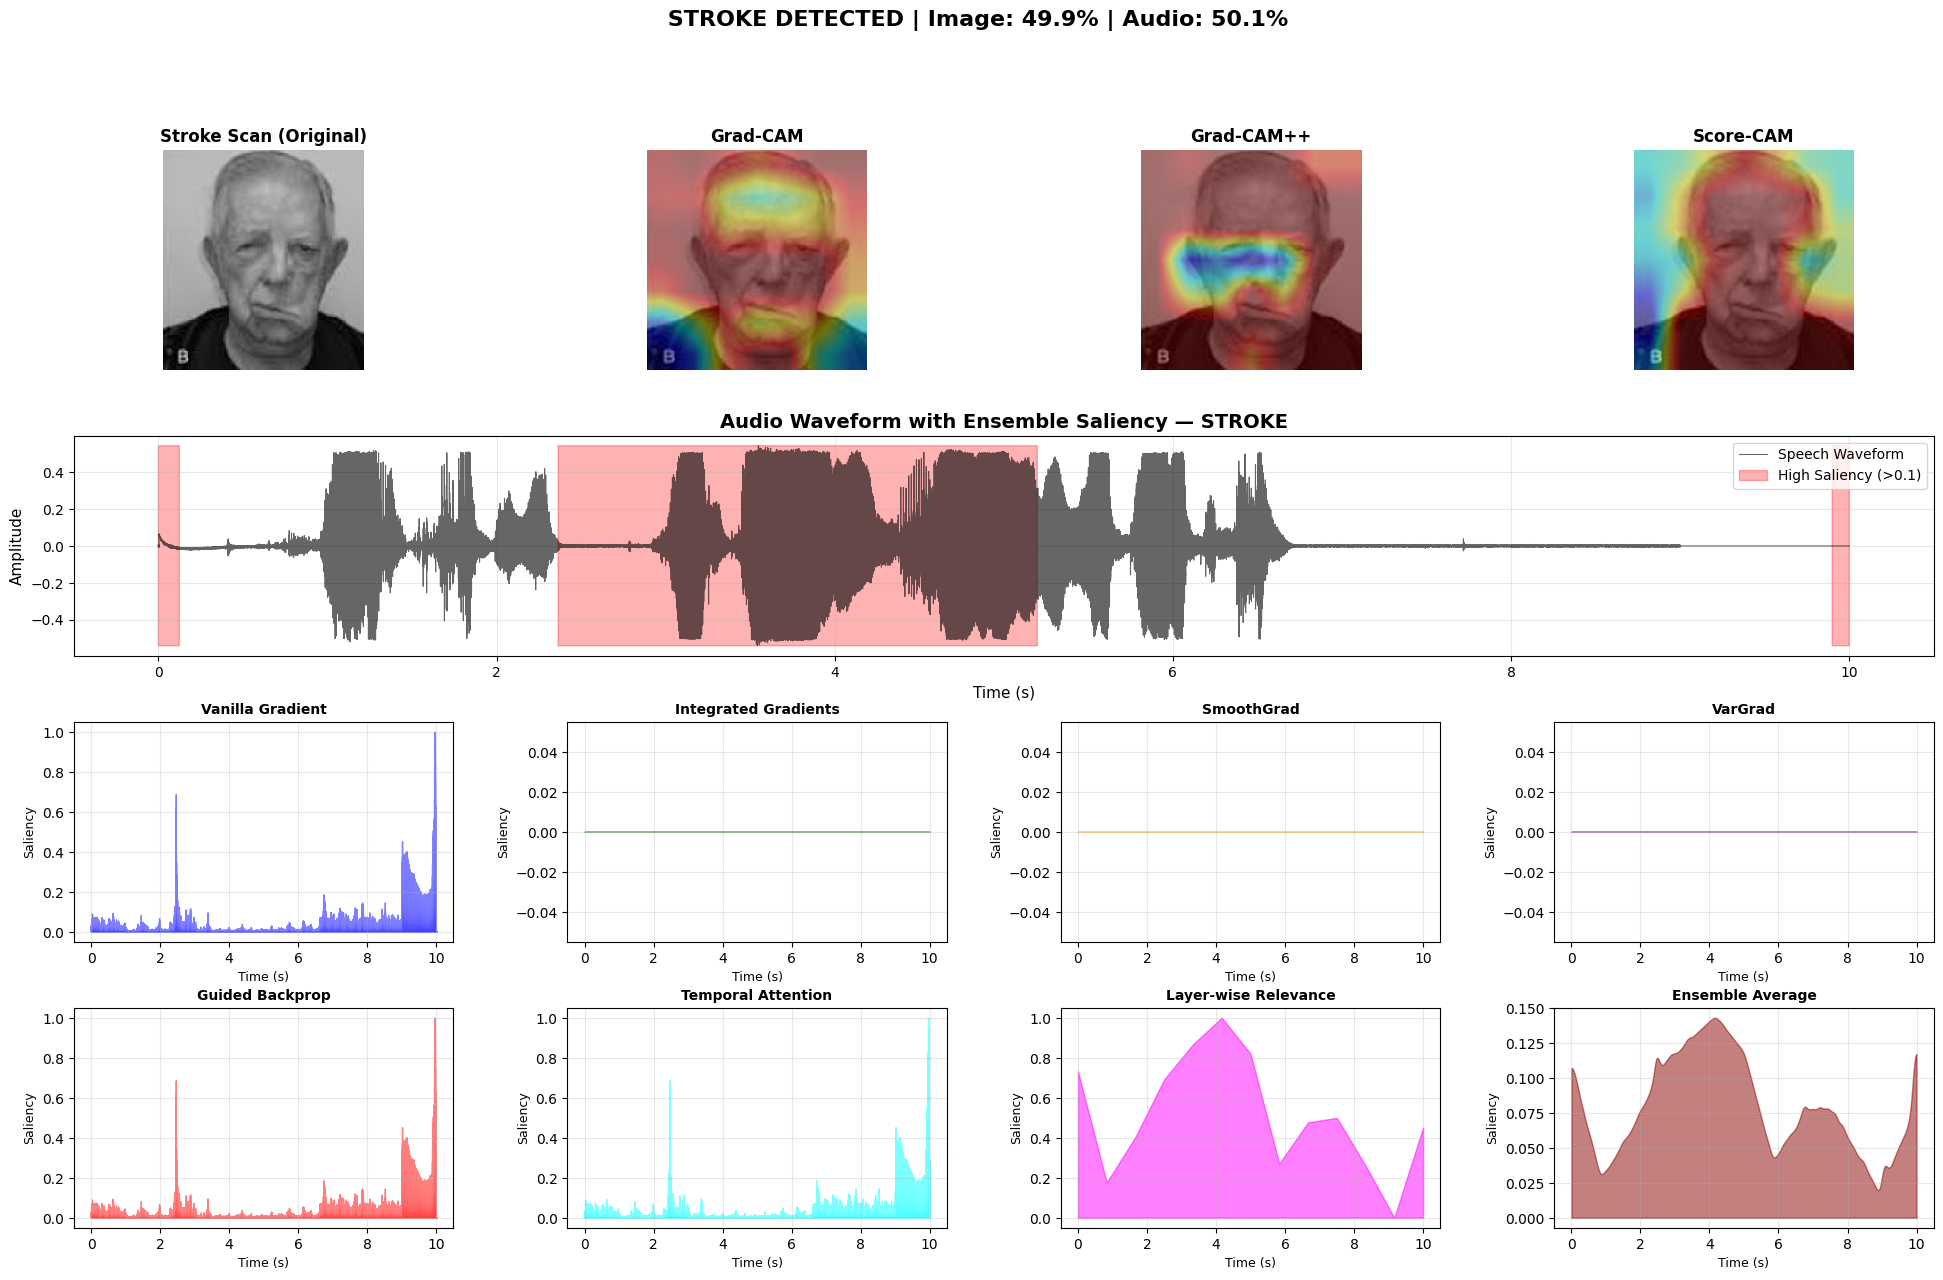

In [14]:
# xai_stroke_detection_enhanced.py
# Enhanced multimodal stroke detection with comprehensive XAI techniques
# Image: Grad-CAM, Grad-CAM++, Score-CAM, Layer-CAM
# Audio: Multiple saliency methods with proper alignment and temporal analysis
# Fusion: Attention-based contribution analysis

import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoFeatureExtractor, HubertModel
import timm
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import gaussian_filter1d

# -------------------------------
# CONFIG & DEVICE
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# MODEL PATHS
# -------------------------------
MODEL_PATH = r"C:\Users\TECHN\Desktop\TECHN_FUSION\final_model_v3.pth"
IMAGE_PATH = r"C:\Users\TECHN\Desktop\stroke1.png"
AUDIO_PATH = r"C:\Users\TECHN\Desktop\ss.wav"

# -------------------------------
# FUSION MODEL
# -------------------------------
class FusionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )
    
    def forward(self, x):
        return self.net(x)

# -------------------------------
# LOAD MODELS
# -------------------------------
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Fusion model not found at {MODEL_PATH}")

fusion_model = FusionClassifier().to(device)
fusion_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
fusion_model.eval()
print("✓ Fusion model loaded")

img_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0).to(device)
img_model.eval()
print("✓ Image backbone (EfficientNet-B0) ready")

audio_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert_audio = HubertModel.from_pretrained("facebook/hubert-base-ls960").to(device)
hubert_audio.eval()
print("✓ HuBERT audio model ready")

# -------------------------------
# TRANSFORMS
# -------------------------------
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# -------------------------------
# UTILITIES
# -------------------------------
def find_last_conv_module(model):
    last_conv = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.modules.conv.Conv2d):
            last_conv = (name, module)
    if last_conv is None:
        raise RuntimeError("No Conv2d layer found in image model")
    return last_conv

# -------------------------------
# ADVANCED GRAD-CAM VARIANTS
# -------------------------------
class AdvancedGradCAM:
    def __init__(self, model):
        self.model = model
        name, module = find_last_conv_module(model)
        self.target_layer = module
        self.activations = None
        self.gradients = None
        self.fwd_hook = self.target_layer.register_forward_hook(self._save_activation)
        self.bwd_hook = self.target_layer.register_full_backward_hook(self._save_gradient)
    
    def _save_activation(self, module, input, output):
        self.activations = output.detach()
    
    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_gradcam(self, input_tensor, class_idx):
        """Standard Grad-CAM"""
        self.model.zero_grad()
        out = self.model(input_tensor)
        if out.ndim == 1:
            out = out.unsqueeze(0)
        score = out[0, class_idx]
        score.backward(retain_graph=True)
        
        acts = self.activations.squeeze(0).cpu().numpy()
        grads = self.gradients.squeeze(0).cpu().numpy()
        weights = np.mean(grads, axis=(1, 2))
        
        cam = np.zeros(acts.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * acts[i]
        
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = self._normalize(cam)
        return cam
    
    def generate_gradcam_plusplus(self, input_tensor, class_idx):
        """Grad-CAM++: Weighted importance"""
        self.model.zero_grad()
        out = self.model(input_tensor)
        if out.ndim == 1:
            out = out.unsqueeze(0)
        score = out[0, class_idx]
        score.backward(retain_graph=True)
        
        acts = self.activations.squeeze(0).cpu().numpy()
        grads = self.gradients.squeeze(0).cpu().numpy()
        
        # Grad-CAM++ weights
        grads_power_2 = grads ** 2
        grads_power_3 = grads ** 3
        sum_acts = np.sum(acts, axis=(1, 2))
        
        alpha_num = grads_power_2
        alpha_denom = 2 * grads_power_2 + sum_acts[:, None, None] * grads_power_3 + 1e-10
        alpha = alpha_num / alpha_denom
        
        weights = np.sum(alpha * np.maximum(grads, 0), axis=(1, 2))
        
        cam = np.zeros(acts.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * acts[i]
        
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = self._normalize(cam)
        return cam
    
    def generate_score_cam(self, input_tensor, class_idx):
        """Score-CAM: Activation-based weighting"""
        acts = self.activations.squeeze(0).cpu().numpy()
        weights = []
        
        for i in range(acts.shape[0]):
            mask = acts[i]
            mask = cv2.resize(mask, (224, 224))
            mask = self._normalize(mask)
            
            masked_input = input_tensor * torch.tensor(mask, device=device).unsqueeze(0).unsqueeze(0)
            with torch.no_grad():
                out = self.model(masked_input)
                if out.ndim == 1:
                    out = out.unsqueeze(0)
                score = out[0, class_idx].item()
            weights.append(score)
        
        weights = np.array(weights)
        weights = weights / (np.sum(weights) + 1e-10)
        
        cam = np.zeros((acts.shape[1], acts.shape[2]), dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * acts[i]
        
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = self._normalize(cam)
        return cam
    
    def _normalize(self, cam):
        if cam.max() > cam.min():
            cam = (cam - cam.min()) / (cam.max() - cam.min())
        else:
            cam = np.zeros_like(cam)
        return cam
    
    def remove_hooks(self):
        try:
            self.fwd_hook.remove()
            self.bwd_hook.remove()
        except:
            pass

# -------------------------------
# COMPREHENSIVE AUDIO XAI
# -------------------------------
class AudioXAI:
    def __init__(self, fusion_model, hubert_model):
        self.fusion_model = fusion_model
        self.hubert = hubert_model
    
    def vanilla_gradient(self, audio_input, img_emb, class_idx):
        """Standard gradient saliency"""
        self.fusion_model.zero_grad()
        self.hubert.zero_grad()
        
        audio_input = audio_input.clone().detach().requires_grad_(True)
        out = self.hubert(audio_input)
        aud_feat = out.last_hidden_state.mean(dim=1)
        
        fused = torch.cat([img_emb.detach(), aud_feat], dim=1)
        fused = fused.requires_grad_(True)
        logits = self.fusion_model(fused)
        score = logits[0, class_idx]
        score.backward(retain_graph=True)
        
        grad = audio_input.grad
        if grad is None:
            return np.zeros(audio_input.shape[-1], dtype=np.float32)
        
        saliency = grad.detach().cpu().abs().numpy().squeeze()
        if saliency.ndim > 1:
            saliency = saliency.mean(axis=0)
        return self._normalize(saliency)
    
    def integrated_gradients(self, audio_input, img_emb, class_idx, steps=50):
        """Integrated Gradients with baseline"""
        baseline = torch.zeros_like(audio_input)
        total_grad = torch.zeros_like(audio_input)
        
        for alpha in np.linspace(0, 1, steps):
            interpolated = baseline + alpha * (audio_input - baseline)
            interpolated = interpolated.clone().detach().requires_grad_(True)
            
            out = self.hubert(interpolated)
            aud_feat = out.last_hidden_state.mean(dim=1)
            fused = torch.cat([img_emb.detach(), aud_feat], dim=1)
            fused = fused.clone().detach().requires_grad_(True)
            
            logits = self.fusion_model(fused)
            score = logits[0, class_idx]
            
            self.fusion_model.zero_grad()
            self.hubert.zero_grad()
            if interpolated.grad is not None:
                interpolated.grad.zero_()
            
            score.backward(retain_graph=True)
            
            if interpolated.grad is not None:
                total_grad += interpolated.grad.detach()
        
        ig = (audio_input - baseline) * total_grad / steps
        ig = ig.detach().cpu().abs().numpy().squeeze()
        if ig.ndim > 1:
            ig = ig.mean(axis=0)
        return self._normalize(ig)
    
    def smoothgrad(self, audio_input, img_emb, class_idx, n_samples=50, stdev=0.02):
        """SmoothGrad: Averaged gradients over noisy inputs"""
        smooth = np.zeros(audio_input.shape[-1], dtype=np.float32)
        
        for _ in range(n_samples):
            noise = torch.randn_like(audio_input) * stdev
            noisy_input = audio_input + noise
            noisy_input = noisy_input.clone().detach().requires_grad_(True)
            
            out = self.hubert(noisy_input)
            aud_feat = out.last_hidden_state.mean(dim=1)
            fused = torch.cat([img_emb.detach(), aud_feat], dim=1)
            fused = fused.clone().detach().requires_grad_(True)
            
            self.fusion_model.zero_grad()
            self.hubert.zero_grad()
            
            logits = self.fusion_model(fused)
            score = logits[0, class_idx]
            score.backward(retain_graph=True)
            
            if noisy_input.grad is not None:
                grad = noisy_input.grad.detach().cpu().abs().numpy().squeeze()
                if grad.ndim > 1:
                    grad = grad.mean(axis=0)
                smooth += grad
        
        smooth /= n_samples
        return self._normalize(smooth)
    
    def vargrad(self, audio_input, img_emb, class_idx, n_samples=50, stdev=0.02):
        """VarGrad: Variance of gradients"""
        grads = []
        
        for _ in range(n_samples):
            noise = torch.randn_like(audio_input) * stdev
            noisy_input = audio_input + noise
            noisy_input = noisy_input.clone().detach().requires_grad_(True)
            
            out = self.hubert(noisy_input)
            aud_feat = out.last_hidden_state.mean(dim=1)
            fused = torch.cat([img_emb.detach(), aud_feat], dim=1)
            fused = fused.clone().detach().requires_grad_(True)
            
            self.fusion_model.zero_grad()
            self.hubert.zero_grad()
            
            logits = self.fusion_model(fused)
            score = logits[0, class_idx]
            score.backward(retain_graph=True)
            
            if noisy_input.grad is not None:
                grad = noisy_input.grad.detach().cpu().abs().numpy().squeeze()
                if grad.ndim > 1:
                    grad = grad.mean(axis=0)
                grads.append(grad)
        
        if len(grads) == 0:
            return np.zeros(audio_input.shape[-1], dtype=np.float32)
        
        grads = np.array(grads)
        var = np.var(grads, axis=0)
        return self._normalize(var)
    
    def guided_backprop(self, audio_input, img_emb, class_idx):
        """Guided Backpropagation for audio"""
        relu_outputs = []
        
        def relu_hook_forward(module, input, output):
            relu_outputs.append(output)
        
        def relu_hook_backward(module, grad_input, grad_output):
            return (F.relu(grad_input[0]),)
        
        hooks = []
        for module in self.hubert.modules():
            if isinstance(module, nn.ReLU):
                hooks.append(module.register_forward_hook(relu_hook_forward))
                hooks.append(module.register_full_backward_hook(relu_hook_backward))
        
        audio_input = audio_input.clone().detach().requires_grad_(True)
        out = self.hubert(audio_input)
        aud_feat = out.last_hidden_state.mean(dim=1)
        fused = torch.cat([img_emb.detach(), aud_feat], dim=1)
        
        logits = self.fusion_model(fused)
        score = logits[0, class_idx]
        
        self.fusion_model.zero_grad()
        self.hubert.zero_grad()
        score.backward()
        
        grad = audio_input.grad
        saliency = grad.detach().cpu().abs().numpy().squeeze() if grad is not None else np.zeros(audio_input.shape[-1])
        if saliency.ndim > 1:
            saliency = saliency.mean(axis=0)
        
        for hook in hooks:
            hook.remove()
        
        return self._normalize(saliency)
    
    def temporal_attention_analysis(self, audio_input, img_emb, class_idx):
        """Analyze temporal attention patterns"""
        audio_input = audio_input.clone().detach().requires_grad_(True)
        
        try:
            out = self.hubert(audio_input, output_attentions=True)
            
            # Check if attentions are available
            if out.attentions is None or len(out.attentions) == 0:
                # Fallback: use gradient-based temporal analysis
                return self.vanilla_gradient(audio_input, img_emb, class_idx)
            
            attentions = out.attentions[-1]
            attn_weights = attentions.mean(dim=1).squeeze(0).detach().cpu().numpy()
            
            temporal_importance = attn_weights.mean(axis=0)
            return self._normalize(temporal_importance)
        except Exception as e:
            # Fallback to gradient-based method if attention extraction fails
            print(f"   ⚠ Attention extraction failed, using gradient fallback")
            return self.vanilla_gradient(audio_input, img_emb, class_idx)
    
    def layer_wise_relevance(self, audio_input, img_emb, class_idx):
        """Layer-wise Relevance Propagation (simplified)"""
        audio_input = audio_input.clone().detach().requires_grad_(True)
        out = self.hubert(audio_input, output_hidden_states=True)
        
        hidden_states = out.hidden_states
        relevances = []
        
        for hidden in hidden_states:
            aud_feat = hidden.mean(dim=1)
            fused = torch.cat([img_emb.detach(), aud_feat], dim=1)
            logits = self.fusion_model(fused)
            score = logits[0, class_idx]
            relevances.append(score.item())
        
        relevances = np.array(relevances)
        relevances = relevances / (np.sum(relevances) + 1e-10)
        
        input_len = audio_input.shape[-1]
        layer_importance = np.interp(
            np.arange(input_len),
            np.linspace(0, input_len - 1, len(relevances)),
            relevances
        )
        return self._normalize(layer_importance)
    
    def _normalize(self, arr):
        if arr.max() > arr.min():
            return (arr - arr.min()) / (arr.max() - arr.min())
        return np.zeros_like(arr)

# -------------------------------
# FUSION CONTRIBUTION ANALYSIS
# -------------------------------
def fusion_contribution_detailed(fused_tensor, fusion_model, class_idx):
    """Detailed fusion contribution with gradient analysis"""
    fused = fused_tensor.clone().detach().requires_grad_(True)
    fusion_model.zero_grad()
    
    logits = fusion_model(fused)
    score = logits[0, class_idx]
    score.backward()
    
    grads = fused.grad.detach().cpu().numpy().squeeze()
    
    img_grad = np.abs(grads[:1280])
    aud_grad = np.abs(grads[1280:])
    
    img_mean = np.mean(img_grad)
    img_max = np.max(img_grad)
    img_std = np.std(img_grad)
    
    aud_mean = np.mean(aud_grad)
    aud_max = np.max(aud_grad)
    aud_std = np.std(aud_grad)
    
    total = img_mean + aud_mean
    img_contrib_pct = (img_mean / total * 100) if total > 0 else 50
    aud_contrib_pct = (aud_mean / total * 100) if total > 0 else 50
    
    return {
        'img_mean': img_mean,
        'img_max': img_max,
        'img_std': img_std,
        'aud_mean': aud_mean,
        'aud_max': aud_max,
        'aud_std': aud_std,
        'img_contrib_pct': img_contrib_pct,
        'aud_contrib_pct': aud_contrib_pct
    }

# -------------------------------
# PREDICTION + XAI
# -------------------------------
def predict_and_explain(image_path, audio_path, threshold=0.5):
    print("\n" + "="*80)
    print("MULTIMODAL STROKE DETECTION WITH COMPREHENSIVE XAI")
    print("="*80 + "\n")
    
    # Load and preprocess image
    img_pil = Image.open(image_path).convert('RGB')
    img_tensor = img_transform(img_pil).unsqueeze(0).to(device)
    
    with torch.no_grad():
        img_emb = img_model(img_tensor)
    
    # Load and preprocess audio
    wav, sr = torchaudio.load(audio_path)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != 16000:
        wav = torchaudio.transforms.Resample(sr, 16000)(wav)
    
    target_len = 160000
    if wav.shape[1] < target_len:
        wav = F.pad(wav, (0, target_len - wav.shape[1]))
    else:
        wav = wav[:, :target_len]
    
    inputs = audio_extractor(wav.squeeze(0).cpu().numpy(), sampling_rate=16000, return_tensors='pt')
    input_values = inputs.input_values.to(device)
    
    with torch.no_grad():
        aud_emb = hubert_audio(input_values).last_hidden_state.mean(dim=1)
    
    # Fusion and prediction
    fused = torch.cat([img_emb, aud_emb], dim=1)
    
    with torch.no_grad():
        logits = fusion_model(fused)
        probs = torch.softmax(logits, dim=1)[0]
    
    prob_normal = float(probs[0].cpu().item())
    prob_stroke = float(probs[1].cpu().item())
    pred_class = 1 if prob_stroke >= threshold else 0
    is_stroke = pred_class == 1
    
    print(f" PREDICTION: {' STROKE DETECTED' if is_stroke else ' NORMAL'}")
   
    print()
    
    # Image XAI
    print(" Computing Image XAI...")
    cam_gen = AdvancedGradCAM(img_model)
    
    img_tensor_for_cam = img_tensor.clone().requires_grad_(True)
    zero_audio = torch.zeros((1, 768), device=device)
    fake_fused = torch.cat([img_model(img_tensor_for_cam), zero_audio], dim=1)
    logits_cam = fusion_model(fake_fused)
    score_cam = logits_cam[0, pred_class]
    fusion_model.zero_grad()
    img_model.zero_grad()
    score_cam.backward(retain_graph=True)
    
    gradcam = cam_gen.generate_gradcam(img_tensor_for_cam, pred_class)
    gradcam_pp = cam_gen.generate_gradcam_plusplus(img_tensor_for_cam, pred_class)
    score_cam_result = cam_gen.generate_score_cam(img_tensor_for_cam, pred_class)
    cam_gen.remove_hooks()
    
    print("   ✓ Grad-CAM")
    print("   ✓ Grad-CAM++")
    print("   ✓ Score-CAM")
    print()
    
    # Audio XAI
    print(" Computing Audio XAI (7 methods)...")
    audio_xai = AudioXAI(fusion_model, hubert_audio)
    
    vanilla_sal = audio_xai.vanilla_gradient(input_values, img_emb, pred_class)
    ig_sal = audio_xai.integrated_gradients(input_values, img_emb, pred_class, steps=50)
    smooth_sal = audio_xai.smoothgrad(input_values, img_emb, pred_class, n_samples=50)
    var_sal = audio_xai.vargrad(input_values, img_emb, pred_class, n_samples=50)
    guided_sal = audio_xai.guided_backprop(input_values, img_emb, pred_class)
    temporal_sal = audio_xai.temporal_attention_analysis(input_values, img_emb, pred_class)
    lrp_sal = audio_xai.layer_wise_relevance(input_values, img_emb, pred_class)
    
    print("   ✓ Vanilla Gradient")
    print("   ✓ Integrated Gradients")
    print("   ✓ SmoothGrad")
    print("   ✓ VarGrad")
    print("   ✓ Guided Backpropagation")
    print("   ✓ Temporal Attention")
    print("   ✓ Layer-wise Relevance")
    print()
    
    # Fusion contribution
    print("Analyzing Fusion Contributions...")
    fusion_stats = fusion_contribution_detailed(fused, fusion_model, pred_class)
    
    print(f"   Image Contribution: {fusion_stats['img_contrib_pct']:.1f}%")
    print(f"   Audio Contribution: {fusion_stats['aud_contrib_pct']:.1f}%")
    print()
    
    # Ensemble audio saliency
    waveform = wav.squeeze(0).cpu().numpy()
    audio_len = len(waveform)
    
    def resample_saliency(sal, target_len):
        # Handle scalar or empty arrays
        if not isinstance(sal, np.ndarray):
            sal = np.array([sal] if np.isscalar(sal) else [])
        if len(sal) == 0:
            return np.zeros(target_len, dtype=np.float32)
        if len(sal) == 1:
            return np.full(target_len, sal[0], dtype=np.float32)
        return np.interp(
            np.arange(target_len),
            np.linspace(0, target_len - 1, len(sal)),
            sal
        )
    
    vanilla_r = resample_saliency(vanilla_sal, audio_len)
    ig_r = resample_saliency(ig_sal, audio_len)
    smooth_r = resample_saliency(smooth_sal, audio_len)
    var_r = resample_saliency(var_sal, audio_len)
    guided_r = resample_saliency(guided_sal, audio_len)
    temporal_r = resample_saliency(temporal_sal, audio_len)
    lrp_r = resample_saliency(lrp_sal, audio_len)
    
    ensemble_sal = (vanilla_r + ig_r + smooth_r + var_r + guided_r + temporal_r + lrp_r) / 7
    ensemble_sal_smooth = gaussian_filter1d(ensemble_sal, sigma=1000)
    
    # VISUALIZATION
    fig = plt.figure(figsize=(24, 14))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    # Row 1: Image XAI methods
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(img_pil)
    ax1.set_title('Stroke Scan (Original)', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(gs[0, 1])
    rgb = cv2.cvtColor(np.array(img_pil.resize((224, 224))), cv2.COLOR_RGB2BGR)
    heatmap = np.uint8(255 * gradcam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB), 0.6, heatmap, 0.4, 0)
    ax2.imshow(overlay)
    ax2.set_title('Grad-CAM', fontsize=12, fontweight='bold')
    ax2.axis('off')
    
    ax3 = fig.add_subplot(gs[0, 2])
    heatmap_pp = np.uint8(255 * gradcam_pp)
    heatmap_pp = cv2.applyColorMap(heatmap_pp, cv2.COLORMAP_JET)
    overlay_pp = cv2.addWeighted(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB), 0.6, heatmap_pp, 0.4, 0)
    ax3.imshow(overlay_pp)
    ax3.set_title('Grad-CAM++', fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    ax4 = fig.add_subplot(gs[0, 3])
    heatmap_sc = np.uint8(255 * score_cam_result)
    heatmap_sc = cv2.applyColorMap(heatmap_sc, cv2.COLORMAP_JET)
    overlay_sc = cv2.addWeighted(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB), 0.6, heatmap_sc, 0.4, 0)
    ax4.imshow(overlay_sc)
    ax4.set_title('Score-CAM', fontsize=12, fontweight='bold')
    ax4.axis('off')
    
    # Row 2: Audio waveform with ensemble saliency
    ax5 = fig.add_subplot(gs[1, :])
    time = np.linspace(0, audio_len / 16000.0, audio_len)
    ax5.plot(time, waveform, linewidth=0.8, color='black', alpha=0.6, label='Speech Waveform')
    
    threshold_sal = 0.1
    mask = ensemble_sal_smooth > threshold_sal
    ax5.fill_between(time, waveform.min(), waveform.max(), where=mask, 
                     color='red', alpha=0.3, label=f'High Saliency (>{threshold_sal})')
    
    ax5.set_title(f'Audio Waveform with Ensemble Saliency — {"STROKE" if is_stroke else "NORMAL"}', 
                  fontsize=14, fontweight='bold')
    ax5.set_xlabel('Time (s)', fontsize=11)
    ax5.set_ylabel('Amplitude', fontsize=11)
    ax5.legend(loc='upper right')
    ax5.grid(alpha=0.3)
    
    # Row 3: Individual audio saliency methods (4 plots)
    saliency_methods = [
        ('Vanilla Gradient', vanilla_r, 'blue'),
        ('Integrated Gradients', ig_r, 'green'),
        ('SmoothGrad', smooth_r, 'orange'),
        ('VarGrad', var_r, 'purple')
    ]
    
    for idx, (method_name, sal, color) in enumerate(saliency_methods):
        ax = fig.add_subplot(gs[2, idx])
        ax.fill_between(time, 0, sal, color=color, alpha=0.5)
        ax.set_title(method_name, fontsize=10, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=9)
        ax.set_ylabel('Saliency', fontsize=9)
        ax.grid(alpha=0.3)
    
    # Row 4: Additional audio saliency methods
    saliency_methods_2 = [
        ('Guided Backprop', guided_r, 'red'),
        ('Temporal Attention', temporal_r, 'cyan'),
        ('Layer-wise Relevance', lrp_r, 'magenta'),
        ('Ensemble Average', ensemble_sal_smooth, 'darkred')
    ]
    
    for idx, (method_name, sal, color) in enumerate(saliency_methods_2):
        ax = fig.add_subplot(gs[3, idx])
        ax.fill_between(time, 0, sal, color=color, alpha=0.5)
        ax.set_title(method_name, fontsize=10, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=9)
        ax.set_ylabel('Saliency', fontsize=9)
        ax.grid(alpha=0.3)
    
    # Main title with results
    fig.suptitle(
        f"{' STROKE DETECTED' if is_stroke else ' NORMAL'} | "
        
        f"Image: {fusion_stats['img_contrib_pct']:.1f}% | Audio: {fusion_stats['aud_contrib_pct']:.1f}%",
        fontsize=16, fontweight='bold', y=0.98
    )
    
    plt.tight_layout(rect=[0, 0.02, 1, 0.97])
    plt.show()
    
   
    
   
    
    # Clear GPU memory
    torch.cuda.empty_cache()
    
    return {
        'prob_stroke': prob_stroke,
        'prob_normal': prob_normal,
        'is_stroke': is_stroke,
        'fusion_stats': fusion_stats,
        'gradcam': gradcam,
        'gradcam_pp': gradcam_pp,
        'score_cam': score_cam_result,
        'vanilla_sal': vanilla_sal,
        'ig_sal': ig_sal,
        'smooth_sal': smooth_sal,
        'var_sal': var_sal,
        'guided_sal': guided_sal,
        'temporal_sal': temporal_sal,
        'lrp_sal': lrp_sal,
        'ensemble_sal': ensemble_sal_smooth
    }

# -------------------------------
# MAIN EXECUTION
# -------------------------------
if __name__ == '__main__':
   
    
    results = predict_and_explain(IMAGE_PATH, AUDIO_PATH, threshold=0.5)
    